In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Wczytujemy i walidujemy zbiór

In [2]:
y = pd.read_csv('hyperplane/rotatingHyperplane.labels', sep=" ", header=None, squeeze=True)

In [3]:
y.shape

(200000,)

In [4]:
data = pd.read_csv('hyperplane/rotatingHyperplane.data', sep=" ", header=None)

In [5]:
data.shape

(200000, 10)

In [6]:
X_old = data.iloc[range(2000), :]
X_old.shape

(2000, 10)

In [7]:
X_new = data.iloc[range(18000, 20000), :]
X_new.shape

(2000, 10)

In [8]:
y_old = y.loc[range(2000)]

In [9]:
y_new = y.loc[range(18000, 20000)]

# Budujemy modele na starych i nowych danych

In [10]:
X_old_train, X_old_test, y_old_train, y_old_test = train_test_split(X_old, y_old, test_size=0.2)
rf_old = RandomForestClassifier(n_estimators=50)
rf_old.fit(X_old_train, y_old_train)
y_pred_old = rf_old.predict(X_old_test)
y_score_old = rf_old.predict_proba(X_old_test)[:, 1]
y_pred_old = pd.Series(y_pred_old, y_old_test.index)
residuals_old = y_pred_old - y_score_old

print(accuracy_score(y_old_test, y_pred_old))

0.855


In [11]:
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, test_size=0.2)
rf_new = RandomForestClassifier(n_estimators=50)
rf_new.fit(X_new_train, y_new_train)
y_pred_new = rf_new.predict(X_new_test)
y_score_new = rf_old.predict_proba(X_new_test)[:, 1]
y_pred_new = pd.Series(y_pred_new, y_new_test.index)
residuals_new = y_pred_new - y_score_new

print(accuracy_score(y_new_test, y_pred_new))

0.8375


# Liczymy intersection distance

In [12]:
def caluclate_intersection_distance(x, y, *args, **kwargs):
    hist_x = np.histogram(x, *args, **kwargs)
    hist_y = np.histogram(y, *args, **kwargs)
    intersection = [min(height_x, height_y) 
                    for height_x, height_y in zip(hist_x[0], hist_y[0])]
    return np.array(intersection).mean()


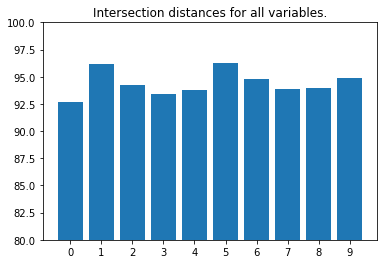

In [13]:
intersection_distances = []
for column in X_old.columns:
    x = X_old[column]
    y = X_new[column]
    intersection_distances.append(caluclate_intersection_distance(x, y, range=(0, 1), bins=20))
    
plt.bar(X_old.columns, intersection_distances)
plt.xticks(X_old.columns)
plt.ylim((80, 100))
plt.title('Intersection distances for all variables.')
plt.show()

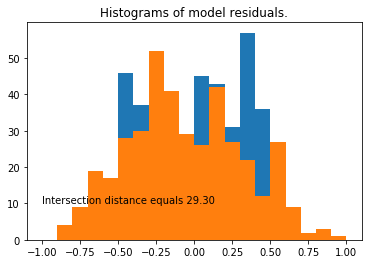

In [14]:
int_dist = caluclate_intersection_distance(residuals_old, residuals_new)
plt.hist(residuals_old, range=(-1, 1), bins=20)
plt.hist(residuals_new, range=(-1, 1), bins=20)
plt.title('Histograms of model residuals.')
plt.text(-1, 10, 'Intersection distance equals {:2.2f}'.format(int_dist))
plt.show()

Wykresy wskazują, że pomimo, iż zmienne objaśniające mają zbliżone rozkłady (wartości intersection distance powyżej 90%), to reszty z modeli charakteryzują się zgoła innymi rozkładami (przecięcie poniżej 30%). Wynika stąd, że mamy do czynienia ze zjawiskiem dryfu w naszym zbiorze danych.

Upewnijmy się, że tak jest poprzez rozważenie krzywych PDP i różnic pomiędzy nimi.

# Liczymy pole pod krzywymi PDP

In [15]:
def calculate_pdp_distances(clf_old, X_old, clf_new, X_new, column):
    # Compute PDP stats.
    mock_column_values = np.linspace(0, 1, 101)
    pdp_stat_old = []
    pdp_stat_new = []
    for mock_column_value in mock_column_values:
        X_old_tmp = X_old.copy()
        X_new_tmp = X_new.copy()
        X_old_tmp[column] = mock_column_value
        X_new_tmp[column] = mock_column_value
        pdp_old = clf_old.predict_proba(X_old_tmp)[:, 1].mean()
        pdp_new = clf_new.predict_proba(X_new_tmp)[:, 1].mean()
        pdp_stat_old.append(pdp_old)
        pdp_stat_new.append(pdp_new)
        
    # Compute area between curves.
    area = np.array([np.abs(old - new) for old, new in zip(pdp_stat_old, pdp_stat_new)]).mean()
    
    # Draw plot.
    
   # plt = fig.add_subplot(1, 1, 1)
    plt.plot(mock_column_values, 
            pdp_stat_old,
            color='blue')
    plt.plot(mock_column_values, 
            pdp_stat_new,
            color='yellow')
    plt.ylim((0, 1))
    plt.fill_between(mock_column_values,
                    pdp_stat_old,
                    pdp_stat_new,
                    where=[True if old >= new else False 
                            for old, new in zip(pdp_stat_old, pdp_stat_new)],
                    facecolor='blue',
                    alpha=0.5)
    plt.fill_between(mock_column_values,
                    pdp_stat_old,
                    pdp_stat_new,
                    where=[True if old < new else False 
                            for old, new in zip(pdp_stat_old, pdp_stat_new)],
                    facecolor='yellow',
                    alpha=0.5)
    plt.text(0.1, 0.1, 'Pole miedzy krzywymi: {:1.3f}'.format(area))
    plt.title('Krzywe PDP dla zmiennej {}.'.format(column))
    plt.show()
    return pdp_stat_new, pdp_stat_old
    

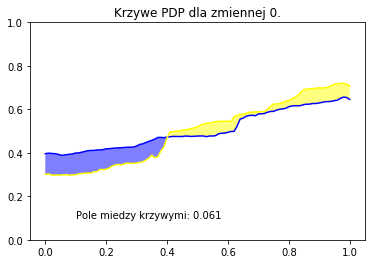

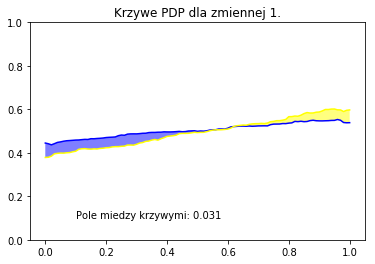

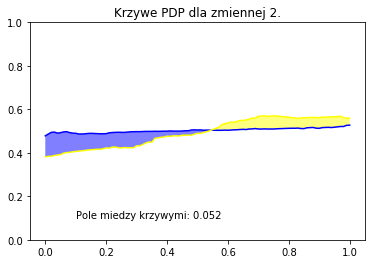

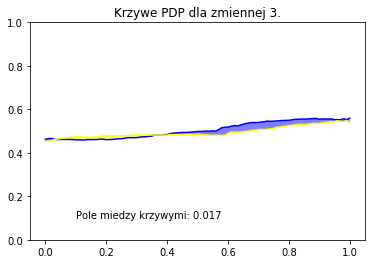

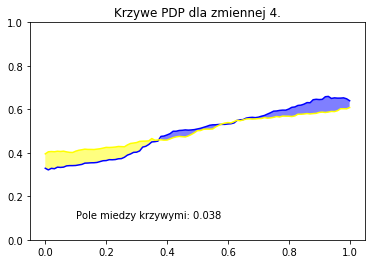

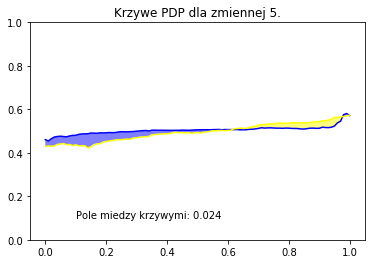

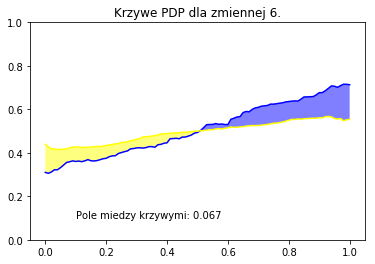

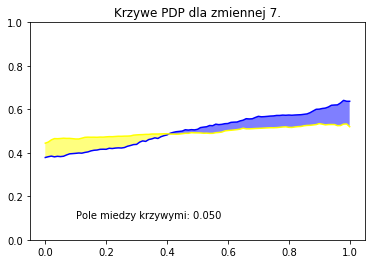

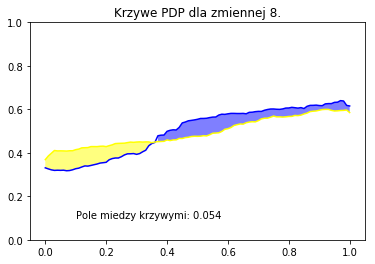

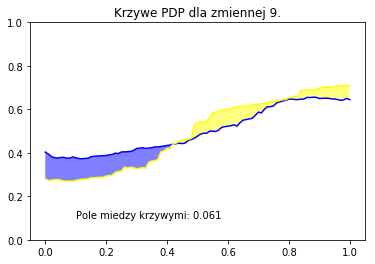

In [16]:
for column in X_old.columns:
    old, new = calculate_pdp_distances(rf_old, X_old, rf_new, X_new, column)

Z wykresów wynika, że niektóre krzywe leżą bardzo blisko siebie, a niektóre są od siebie oddalone. Świadczy to o postępującym dryfie w danych.